In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [4]:
tavily_tool = TavilySearchResults()

In [5]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [6]:
tools = [get_city_details]

In [7]:
model_with_tools = llm.bind_tools(tools)

In [8]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [9]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [10]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [11]:
def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [12]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"

In [13]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [14]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

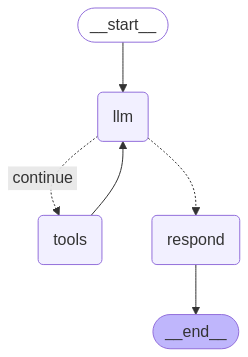

In [15]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='c62b1652-66b6-4a51-b625-e5ebff8e6a99')]}
this is 02 response from call model  content='' additional_kwargs={'tool_calls': [{'id': 'call_8adk', 'function': {'arguments': '{"prompt":"gwalior"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.034050381, 'queue_time': 0.23136293500000002, 'total_time': 0.190414017}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-78b94b13-36c8-45d1-bbcf-acf97d34b3b5-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'gwalior'}, 'id': 'call_8adk', 'type': 'tool_call'}] usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}
 this 

In [17]:
answer

CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', country_name='India', country_capital='New Delhi')